# Simple Time Series Analysis with Census Data

This tutorial teaches you how to analyze changes in demographic data over time using the US Census Bureau's datasets. We'll focus on **geographic levels that don't change over time** (like states and counties) to keep things simple and avoid complex boundary adjustments.

## What You'll Learn

1. **The Golden Rule**: Only compare like survey types (ACS5↔ACS5, Decennial↔Decennial)
2. **Population trends** using decennial census data (2010 vs 2020)
3. **Income trends** using ACS 5-year data (2012 vs 2020)
4. **Best practices** for temporal analysis
5. **Visualization techniques** for demographic change

## Why This Matters

Understanding demographic change over time helps with:
- Urban planning and policy decisions
- Business location and market analysis  
- Research on social and economic trends
- Grant writing and community development

## Setup: Import Libraries and API Key

First, let's import the libraries we need and set up our Census API key.

In [14]:
# Import required libraries
import pytidycensus as tc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Make plots look nicer
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")
print(f"Using pytidycensus version: {tc.__version__}")

Libraries imported successfully!
Using pytidycensus version: 1.0.4


In [15]:
# Set your Census API key here
# Get a free key at: https://api.census.gov/data/key_signup.html

# UNCOMMENT and add your key:
# tc.set_census_api_key("YOUR_API_KEY_HERE")

print(" Remember to set your Census API key above!")
print("   Get one free at: https://api.census.gov/data/key_signup.html")

 Remember to set your Census API key above!
   Get one free at: https://api.census.gov/data/key_signup.html


## The Golden Rule of Census Time Series

**CRITICAL**: Only compare surveys of the same type!

### ✅ CORRECT Comparisons
- **Decennial 2010 ↔ Decennial 2020**: Complete population counts
- **ACS 5-year 2012 ↔ ACS 5-year 2020**: Same methodology, sample size
- **ACS 1-year 2019 ↔ ACS 1-year 2021**: Recent estimates for large areas

### ❌ WRONG Comparisons
- **ACS 1-year ↔ ACS 5-year**: Different sample sizes and time periods
- **Decennial ↔ ACS**: Different methodologies (complete count vs. sample)

### Why This Matters

In [16]:
# Let's demonstrate why survey type matters
print("SURVEY TYPE COMPARISON:")
print("=" * 50)
print("DECENNIAL CENSUS:")
print("   • Complete count of all households")
print("   • Very low margin of error")
print("   • Every 10 years (2010, 2020, 2030...)")
print("   • Best for: Long-term trends, small areas")
print()
print("ACS 5-YEAR:")
print("   • Sample survey (~3.5M addresses/year)")
print("   • 5 years of data combined for stability")
print("   • Available for all geographies")
print("   • Best for: Small areas, stable trends")
print()
print("ACS 1-YEAR:")
print("   • Sample survey (~3.5M addresses/year)")
print("   • Single year of data")
print("   • Only areas with 65,000+ population")
print("   • Best for: Large areas, recent trends")

SURVEY TYPE COMPARISON:
DECENNIAL CENSUS:
   • Complete count of all households
   • Very low margin of error
   • Every 10 years (2010, 2020, 2030...)
   • Best for: Long-term trends, small areas

ACS 5-YEAR:
   • Sample survey (~3.5M addresses/year)
   • 5 years of data combined for stability
   • Available for all geographies
   • Best for: Small areas, stable trends

ACS 1-YEAR:
   • Sample survey (~3.5M addresses/year)
   • Single year of data
   • Only areas with 65,000+ population
   • Best for: Large areas, recent trends


## Part 1: Population Change Analysis (Decennial Census)

Let's start by analyzing population changes in the Washington DC metro area between 2010 and 2020 using decennial census data. We'll compare **DC, Maryland, and Virginia** at the state level.

### Why Use State Level?
- State boundaries don't change over time
- No need for complex boundary adjustments
- Reliable and straightforward comparison

In [17]:
# Step 1: Get 2010 population data for DC metro states
print("   Fetching 2010 decennial census data...")
print("   Variable: P001001 (Total Population)")

# Define the states we want to analyze
metro_states = ["DC", "MD", "VA"]

# Get 2010 data
pop_2010 = tc.get_decennial(
    geography="state",
    variables={"total_pop": "P001001"},  # P001001 = Total Population in 2010
    state=metro_states,
    year=2010,
    output="wide"  # Wide format puts variables as columns
)

print(f"Retrieved data for {len(pop_2010)} states")
print("\n2010 Population Data:")
print(pop_2010[['NAME', 'total_pop']].to_string(index=False))

   Fetching 2010 decennial census data...
   Variable: P001001 (Total Population)
Getting data from the 2010 decennial Census
Using Census Summary File 1
Retrieved data for 3 states

2010 Population Data:
    NAME  total_pop
      DC     601723
Maryland    5773552
Virginia    8001024


In [18]:
# Step 2: Get 2020 population data
print("   Fetching 2020 decennial census data...")
print("   Variable: P1_001N (Total Population)")
print("   Note: Variable codes changed between 2010 and 2020!")

# Get 2020 data - NOTE: Different variable code!
pop_2020 = tc.get_decennial(
    geography="state",
    variables={"total_pop": "P1_001N"},  # P1_001N = Total Population in 2020
    state=metro_states,
    year=2020,
    output="wide"
)

print(f"Retrieved data for {len(pop_2020)} states")
print("\n2020 Population Data:")
print(pop_2020[['NAME', 'total_pop']].to_string(index=False))

   Fetching 2020 decennial census data...
   Variable: P1_001N (Total Population)
   Note: Variable codes changed between 2010 and 2020!
Getting data from the 2020 decennial Census
Using the PL 94-171 Redistricting Data Summary File
Retrieved data for 3 states

2020 Population Data:
    NAME  total_pop
      DC     689545
Maryland    6177224
Virginia    8631393


/home/mmann1123/Documents/github/pytidycensus/pytidycensus/decennial.py:429: UserWarning: Note: 2020 decennial Census data use differential privacy, a technique that introduces errors into data to preserve respondent confidentiality. Small counts should be interpreted with caution. See https://www.census.gov/library/fact-sheets/2021/protecting-the-confidentiality-of-the-2020-census-redistricting-data.html for additional guidance.
  warnings.warn(


### 🔍 Key Learning Point: Variable Codes Change!

Notice that we used different variable codes:
- **2010**: `P001001` 
- **2020**: `P1_001N`

This is common when comparing across census years. Always check variable definitions!

In [19]:
# Step 3: Merge the data and calculate changes
print("   Calculating population changes...")

# Merge 2010 and 2020 data on state name
pop_change = pd.merge(
    pop_2010[['NAME', 'total_pop']].rename(columns={'total_pop': 'pop_2010'}),
    pop_2020[['NAME', 'total_pop']].rename(columns={'total_pop': 'pop_2020'}),
    on='NAME'
)

# Calculate absolute and percentage changes
pop_change['change_absolute'] = pop_change['pop_2020'] - pop_change['pop_2010']
pop_change['change_percent'] = (pop_change['change_absolute'] / pop_change['pop_2010']) * 100

print("Population change analysis complete!")
print("\nPopulation Change Summary (2010-2020):")
print("=" * 60)

for _, row in pop_change.iterrows():
    print(f"{row['NAME']}:")
    print(f"   2010: {row['pop_2010']:,}")
    print(f"   2020: {row['pop_2020']:,}")
    print(f"   Change: {row['change_absolute']:+,} ({row['change_percent']:+.1f}%)")
    print()

   Calculating population changes...
Population change analysis complete!

Population Change Summary (2010-2020):
DC:
   2010: 601,723
   2020: 689,545
   Change: +87,822 (+14.6%)

Maryland:
   2010: 5,773,552
   2020: 6,177,224
   Change: +403,672 (+7.0%)

Virginia:
   2010: 8,001,024
   2020: 8,631,393
   Change: +630,369 (+7.9%)



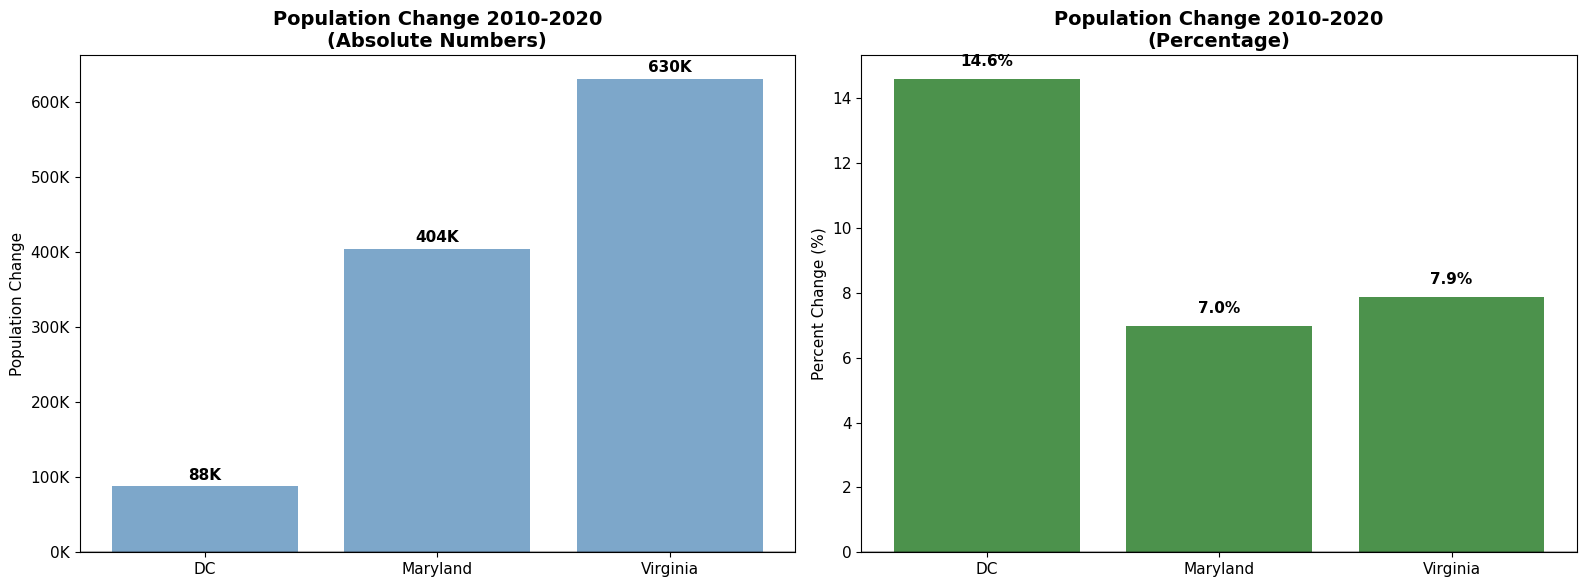

DC METRO AREA SUMMARY:
   Total 2010 Population: 14,376,299
   Total 2020 Population: 15,498,162
   Net Change: +1,121,863 (+7.8%)


In [20]:
# Step 4: Visualize the population changes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Absolute change
colors = ['red' if x < 0 else 'steelblue' for x in pop_change['change_absolute']]
bars1 = ax1.bar(pop_change['NAME'], pop_change['change_absolute'], color=colors, alpha=0.7)
ax1.set_title('Population Change 2010-2020\n(Absolute Numbers)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Population Change')
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))

# Add value labels on bars
for bar, value in zip(bars1, pop_change['change_absolute']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + (5000 if height >= 0 else -15000),
             f'{value/1000:.0f}K', ha='center', va='bottom' if height >= 0 else 'top', fontweight='bold')

# Chart 2: Percentage change
colors2 = ['red' if x < 0 else 'darkgreen' for x in pop_change['change_percent']]
bars2 = ax2.bar(pop_change['NAME'], pop_change['change_percent'], color=colors2, alpha=0.7)
ax2.set_title('Population Change 2010-2020\n(Percentage)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Percent Change (%)')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars2, pop_change['change_percent']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + (0.3 if height >= 0 else -0.8),
             f'{value:.1f}%', ha='center', va='bottom' if height >= 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary statistics
total_2010 = pop_change['pop_2010'].sum()
total_2020 = pop_change['pop_2020'].sum()
total_change = total_2020 - total_2010
total_pct = (total_change / total_2010) * 100

print(f"DC METRO AREA SUMMARY:")
print(f"   Total 2010 Population: {total_2010:,}")
print(f"   Total 2020 Population: {total_2020:,}")
print(f"   Net Change: {total_change:+,} ({total_pct:+.1f}%)")

## Part 2: Income Change Analysis (ACS 5-Year Data)

Now let's analyze how median household income changed in the DC metro area using **ACS 5-year data**. We'll compare 2012 (2008-2012 ACS) with 2020 (2016-2020 ACS).

### Why These Years?
- **2012 ACS 5-year**: Represents 2008-2012 period (pre-recession recovery)
- **2020 ACS 5-year**: Represents 2016-2020 period (recent data)
- **8-year gap**: Provides meaningful temporal separation

### County-Level Analysis
We'll look at specific counties in the DC metro area that are economically important.

In [21]:
# Define the counties we want to analyze
counties_to_analyze = [
    {"state": "DC", "county": None, "display_name": "Washington DC"},
    {"state": "MD", "county": "Montgomery County", "display_name": "Montgomery County, MD"},
    {"state": "VA", "county": "Arlington County", "display_name": "Arlington County, VA"},
    {"state": "VA", "county": "Fairfax County", "display_name": "Fairfax County, VA"}
]

print("Target Counties for Income Analysis:")
for county in counties_to_analyze:
    print(f"   • {county['display_name']}")
print()
print("Variable: B19013_001E (Median Household Income)")
print("Comparing: 2012 ACS 5-year vs 2020 ACS 5-year")

Target Counties for Income Analysis:
   • Washington DC
   • Montgomery County, MD
   • Arlington County, VA
   • Fairfax County, VA

Variable: B19013_001E (Median Household Income)
Comparing: 2012 ACS 5-year vs 2020 ACS 5-year


In [22]:
# Step 1: Get 2012 ACS income data
print("Fetching 2012 ACS 5-year data (2008-2012)...")

income_2012_data = []

for county_info in counties_to_analyze:
    try:
        income_data = tc.get_acs(
            geography="county",
            variables={"median_income": "B19013_001E"},
            state=county_info["state"],
            county=county_info["county"],  # None for DC (state-equivalent)
            year=2012,
            survey="acs5",
            output="wide"
        )
        
        # Add display name for easier tracking
        income_data['display_name'] = county_info['display_name']
        income_2012_data.append(income_data)
        
        print(f"    {county_info['display_name']}: ${income_data.iloc[0]['median_income']:,}")
        
    except Exception as e:
        print(f"    {county_info['display_name']}: Error - {str(e)[:50]}...")

# Combine all 2012 data
if income_2012_data:
    income_2012_combined = pd.concat(income_2012_data, ignore_index=True)
    print(f"\n Successfully retrieved 2012 data for {len(income_2012_combined)} counties")
else:
    print("\n  No 2012 data retrieved")

Fetching 2012 ACS 5-year data (2008-2012)...
Getting data from the 2008-2012 5-year ACS
    Washington DC: $64,267
Getting data from the 2008-2012 5-year ACS
    Montgomery County, MD: $96,985
Getting data from the 2008-2012 5-year ACS
    Arlington County, VA: $102,459
Getting data from the 2008-2012 5-year ACS
    Fairfax County, VA: $109,383

 Successfully retrieved 2012 data for 4 counties


In [23]:
# Step 2: Get 2020 ACS income data
print("Fetching 2020 ACS 5-year data (2016-2020)...")

income_2020_data = []

for county_info in counties_to_analyze:
    try:
        income_data = tc.get_acs(
            geography="county",
            variables={"median_income": "B19013_001E"},
            state=county_info["state"],
            county=county_info["county"],
            year=2020,
            survey="acs5",
            output="wide"
        )
        
        income_data['display_name'] = county_info['display_name']
        income_2020_data.append(income_data)
        
        print(f"    {county_info['display_name']}: ${income_data.iloc[0]['median_income']:,}")
        
    except Exception as e:
        print(f"    {county_info['display_name']}: Error - {str(e)[:50]}...")

# Combine all 2020 data
if income_2020_data:
    income_2020_combined = pd.concat(income_2020_data, ignore_index=True)
    print(f"\n Successfully retrieved 2020 data for {len(income_2020_combined)} counties")
else:
    print("\n No 2020 data retrieved")

Fetching 2020 ACS 5-year data (2016-2020)...
Getting data from the 2016-2020 5-year ACS
    Washington DC: $90,842
Getting data from the 2016-2020 5-year ACS
    Montgomery County, MD: $111,812
Getting data from the 2016-2020 5-year ACS
    Arlington County, VA: $122,604
Getting data from the 2016-2020 5-year ACS
    Fairfax County, VA: $127,866

 Successfully retrieved 2020 data for 4 counties


In [24]:
# Step 3: Calculate income changes
if 'income_2012_combined' in locals() and 'income_2020_combined' in locals():
    print("   Calculating income changes...")
    
    # Merge data on display name
    income_change = pd.merge(
        income_2012_combined[['display_name', 'median_income']].rename(columns={'median_income': 'income_2012'}),
        income_2020_combined[['display_name', 'median_income']].rename(columns={'median_income': 'income_2020'}),
        on='display_name'
    )
    
    # Calculate changes
    income_change['change_absolute'] = income_change['income_2020'] - income_change['income_2012']
    income_change['change_percent'] = (income_change['change_absolute'] / income_change['income_2012']) * 100
    
    print(" Income change analysis complete!")
    print("\nMedian Income Change Summary (2012-2020):")
    print("=" * 70)
    
    for _, row in income_change.iterrows():
        print(f" {row['display_name']}:")
        print(f"   2012: ${row['income_2012']:,}")
        print(f"   2020: ${row['income_2020']:,}")
        print(f"   Change: ${row['change_absolute']:+,} ({row['change_percent']:+.1f}%)")
        print()
else:
    print("Cannot calculate changes - missing data")
    income_change = pd.DataFrame()  # Empty dataframe for later checks

   Calculating income changes...
 Income change analysis complete!

Median Income Change Summary (2012-2020):
 Washington DC:
   2012: $64,267
   2020: $90,842
   Change: $+26,575 (+41.4%)

 Montgomery County, MD:
   2012: $96,985
   2020: $111,812
   Change: $+14,827 (+15.3%)

 Arlington County, VA:
   2012: $102,459
   2020: $122,604
   Change: $+20,145 (+19.7%)

 Fairfax County, VA:
   2012: $109,383
   2020: $127,866
   Change: $+18,483 (+16.9%)



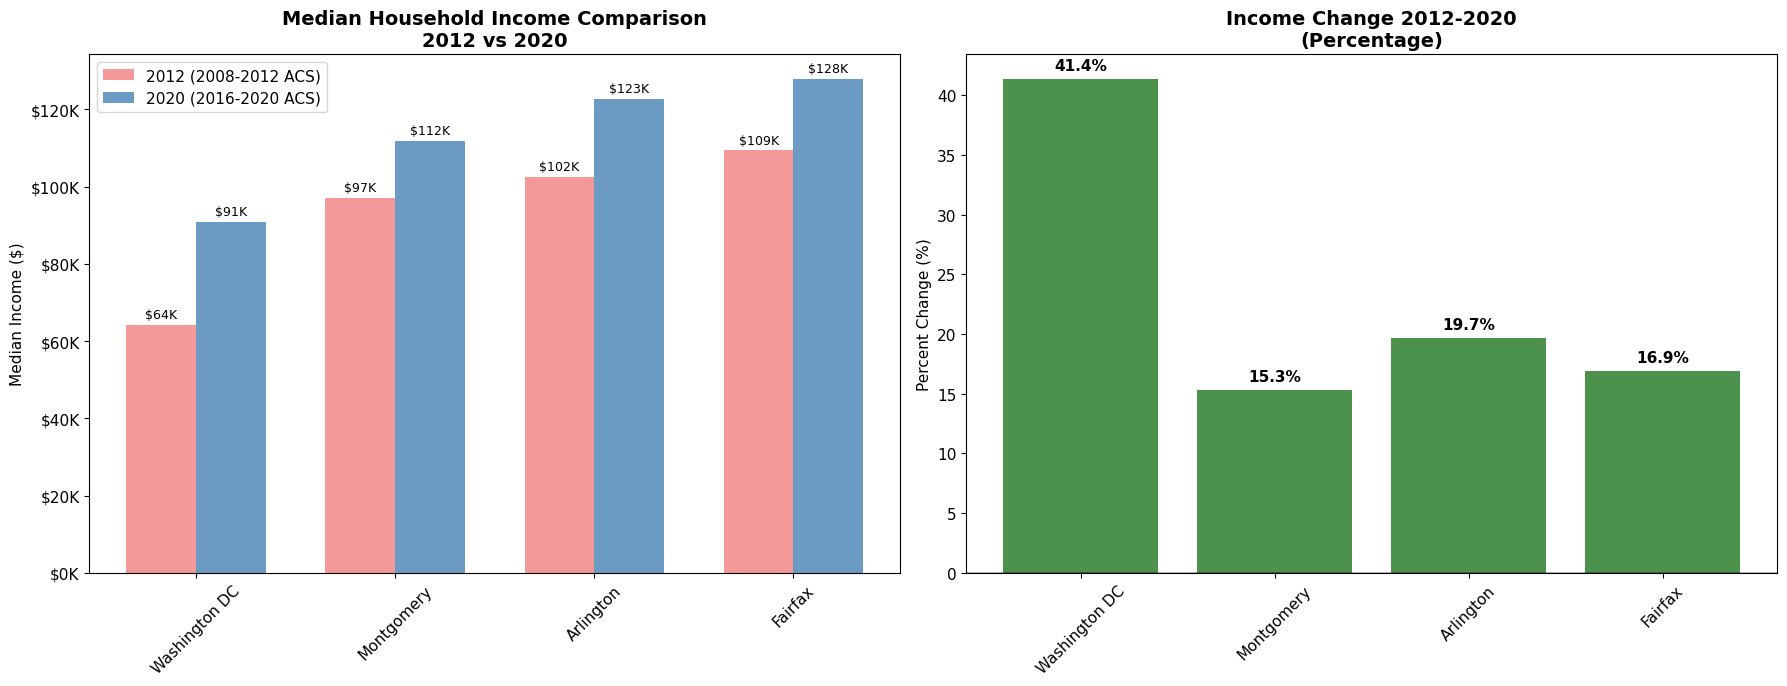

INCOME ANALYSIS SUMMARY:
   Average income change: 23.3%
   Counties with income growth: 4
   Counties with income decline: 0


In [25]:
# Step 4: Visualize income changes
if not income_change.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Chart 1: Income levels comparison
    x = np.arange(len(income_change))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, income_change['income_2012'], width, 
                    label='2012 (2008-2012 ACS)', color='lightcoral', alpha=0.8)
    bars2 = ax1.bar(x + width/2, income_change['income_2020'], width,
                    label='2020 (2016-2020 ACS)', color='steelblue', alpha=0.8)
    
    ax1.set_title('Median Household Income Comparison\n2012 vs 2020', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Median Income ($)')
    ax1.set_xticks(x)
    ax1.set_xticklabels([name.replace(' County', '').replace(', VA', '').replace(', MD', '') 
                        for name in income_change['display_name']], rotation=45)
    ax1.legend()
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1000,
                f'${height/1000:.0f}K', ha='center', va='bottom', fontsize=9)
    
    for bar in bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1000,
                f'${height/1000:.0f}K', ha='center', va='bottom', fontsize=9)
    
    # Chart 2: Percentage change
    colors = ['red' if x < 0 else 'darkgreen' for x in income_change['change_percent']]
    bars3 = ax2.bar(income_change['display_name'].str.replace(' County', '').str.replace(', VA', '').str.replace(', MD', ''),
                    income_change['change_percent'], color=colors, alpha=0.7)
    
    ax2.set_title('Income Change 2012-2020\n(Percentage)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Percent Change (%)')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, value in zip(bars3, income_change['change_percent']):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height >= 0 else -1.5),
                f'{value:.1f}%', ha='center', va='bottom' if height >= 0 else 'top', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    avg_change = income_change['change_percent'].mean()
    print(f"INCOME ANALYSIS SUMMARY:")
    print(f"   Average income change: {avg_change:.1f}%")
    print(f"   Counties with income growth: {(income_change['change_percent'] > 0).sum()}")
    print(f"   Counties with income decline: {(income_change['change_percent'] < 0).sum()}")
    
else:
    print("   Cannot create visualization - no income data available")
    print("   This might be due to API key issues or data availability")

## Part 3: Understanding Your Results

### What Do These Numbers Mean?

**Population Changes (Decennial Census)**
- Shows actual population growth or decline
- DC typically shows high growth due to urban revitalization
- Suburban areas may show different patterns

**Income Changes (ACS 5-Year)**
- Reflects economic conditions over time
- Adjusted for inflation, this shows real purchasing power changes
- High-income areas often show faster income growth

### Important Considerations

In [26]:
# Let's discuss data quality and limitations
print("  IMPORTANT DATA QUALITY CONSIDERATIONS:")
print("=" * 50)
print()
print(" DECENNIAL CENSUS:")
print("    Advantages:")
print("      • Complete population count (not a sample)")
print("      • Very accurate for population totals")
print("      • Available for all geographic levels")
print("    Limitations:")
print("      • Only every 10 years")
print("      • Limited variables (basic demographics only)")
print("      • 2020 data uses differential privacy (slight noise added)")
print()
print(" ACS 5-YEAR:")
print("    Advantages:")
print("      • Rich set of variables (income, education, housing, etc.)")
print("      • Annual updates")
print("      • Available for small geographies")
print("    Limitations:")
print("      • Sample-based (margins of error)")
print("      • 5-year averages may mask recent changes")
print("      • Smaller areas have larger margins of error")
print()
print(" BEST PRACTICES:")
print("   • Always check margins of error for ACS data")
print("   • Consider real vs. nominal changes (adjust for inflation)")
print("   • Look for consistent patterns across multiple indicators")
print("   • Document your methodology and assumptions")

  IMPORTANT DATA QUALITY CONSIDERATIONS:

 DECENNIAL CENSUS:
    Advantages:
      • Complete population count (not a sample)
      • Very accurate for population totals
      • Available for all geographic levels
    Limitations:
      • Only every 10 years
      • Limited variables (basic demographics only)
      • 2020 data uses differential privacy (slight noise added)

 ACS 5-YEAR:
    Advantages:
      • Rich set of variables (income, education, housing, etc.)
      • Annual updates
      • Available for small geographies
    Limitations:
      • Sample-based (margins of error)
      • 5-year averages may mask recent changes
      • Smaller areas have larger margins of error

 BEST PRACTICES:
   • Always check margins of error for ACS data
   • Consider real vs. nominal changes (adjust for inflation)
   • Look for consistent patterns across multiple indicators
   • Document your methodology and assumptions


## Part 4: Advanced Topics and Next Steps

### When Geographic Boundaries Change

For this tutorial, we used **states and counties** because their boundaries are stable over time. But what if you need to analyze **census tracts** or other small geographies that change?

**Solution: Area Interpolation**
- Use the `tobler` library's `area_interpolate()` function
- Redistributes data from old boundaries to new boundaries
- Accounts for how areas were split or merged

See our advanced tutorial: `time_series_analysis.md` for tract-level analysis with boundary changes.

## Summary: Key Takeaways

### What You've Learned

1. **The Golden Rule**: Only compare like survey types
   - Decennial ↔ Decennial for population counts
   - ACS 5-year ↔ ACS 5-year for detailed demographics

2. **Geographic Strategy**: Use stable boundaries when possible
   - States and counties don't change over time
   - Avoids complex boundary adjustments

3. **Variable Consistency**: Check codes across years
   - 2010: `P001001` vs 2020: `P1_001N` for population
   - ACS variables are generally more consistent

4. **Data Quality**: Understand limitations
   - Decennial = complete count, ACS = sample
   - Check margins of error for ACS data
   - Consider real vs. nominal changes

### Practical Applications

- **Urban Planning**: Population growth patterns
- **Economic Development**: Income trend analysis  
- **Policy Research**: Demographic change impacts
- **Business Analysis**: Market area dynamics

### Your Assignment

Try this analysis with your own area of interest:
1. Pick 3-4 states or counties
2. Run the population change analysis
3. Add income or another ACS variable
4. Create your own visualizations
5. Write a brief interpretation of the results

**Happy analyzing!**